In [131]:
from descriptive_statistics import DiabetesDataBase
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

## Read in and split data

In [132]:
csv_path = "diabetes.csv"
ddb = DiabetesDataBase(csv_path)
X_train, X_val, X_test, y_train, y_val, y_test = ddb.splitData()

Shape before removing values that are 0: (768, 9)
Shape after removing values that are 0: (532, 9)


## KNN Model

In [133]:
k_range = list(range(1, 31))
distance_metrics = ['euclidean','manhattan']
weight_options = ['uniform','distance']
param_grid = dict(classifier__n_neighbors=k_range,
                  classifier__metric=distance_metrics,
                  classifier__weights=weight_options)
knn_clf = KNeighborsClassifier()
pipe = Pipeline(steps=[("classifier", knn_clf)])
clf_GS = GridSearchCV(pipe, param_grid, return_train_score=True)
# training is done on the train set!!
clf_GS.fit(X_train, y_train)

# print best values for each parameter
for key in param_grid.keys():
    print(f'Best {key}:', clf_GS.best_estimator_.get_params()[f'{key}'])
print(clf_GS.best_estimator_.get_params()['classifier'])

Best classifier__n_neighbors: 15
Best classifier__metric: manhattan
Best classifier__weights: uniform
KNeighborsClassifier(metric='manhattan', n_neighbors=15)


Accuracy: 0.7333333333333333
Precision: [0.74468085 0.69230769]
Recall: [0.8974359  0.42857143]


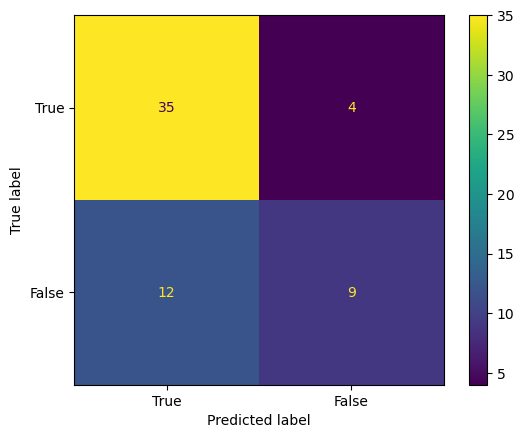

In [134]:
# use best estimator to predict on the validation set
y_pred = clf_GS.best_estimator_.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average=None)
recall = recall_score(y_val, y_pred, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# show confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[True,False])
disp.plot()

## Decision Tree

In [135]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

param_grid = dict(classifier__criterion=criterion,
                classifier__max_depth=max_depth)

decision_tree_clf = DecisionTreeClassifier()
pipe = Pipeline(steps=[("classifier", decision_tree_clf)])
clf_GS = GridSearchCV(pipe, param_grid, return_train_score=True)
# training is done on the train set!!
clf_GS.fit(X_train, y_train)

# print best values for each parameter
for key in param_grid.keys():
    print(f'Best {key}:', clf_GS.best_estimator_.get_params()[f'{key}'])
print(clf_GS.best_estimator_.get_params()['classifier'])

Best classifier__criterion: entropy
Best classifier__max_depth: 4
DecisionTreeClassifier(criterion='entropy', max_depth=4)


Accuracy: 0.7166666666666667
Precision: [0.75  0.625]
Recall: [0.84615385 0.47619048]


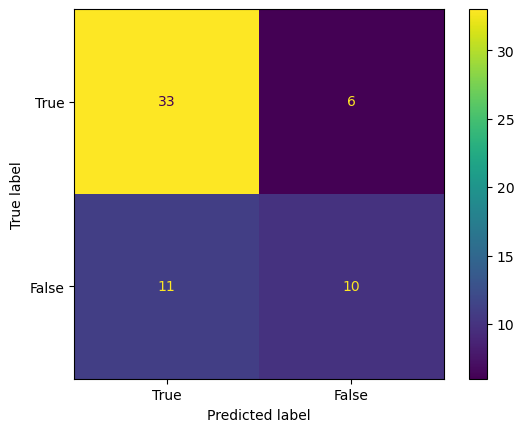

In [136]:
# use best estimator to predict on the validation set
y_pred = clf_GS.best_estimator_.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average=None)
recall = recall_score(y_val, y_pred, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# show confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[True,False])
disp.plot()

## Logistic Regression

If time do grid search for penalty (l1, l2, elasticnet)

              precision    recall  f1-score   support

           0       0.79      0.85      0.81        39
           1       0.67      0.57      0.62        21

    accuracy                           0.75        60
   macro avg       0.73      0.71      0.72        60
weighted avg       0.74      0.75      0.75        60



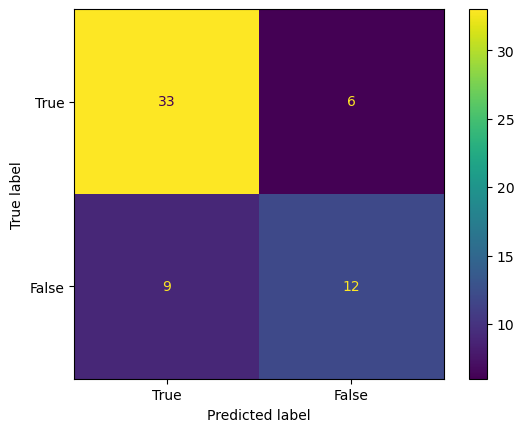

In [137]:
log_reg = LogisticRegression()
standard_scaler = StandardScaler()
regression_pipe = make_pipeline(standard_scaler, log_reg)

regression_pipe.fit(X_train, y_train)
predictions = regression_pipe.predict(X_val)
perfromance = classification_report(y_val, predictions)
print(perfromance)

cm = confusion_matrix(y_val, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[True,False])
disp.plot()

## SVM

              precision    recall  f1-score   support

           0       0.77      0.85      0.80        39
           1       0.65      0.52      0.58        21

    accuracy                           0.73        60
   macro avg       0.71      0.68      0.69        60
weighted avg       0.73      0.73      0.73        60



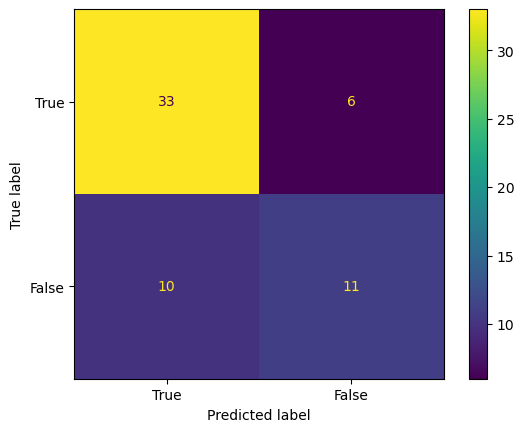

In [138]:
from sklearn.svm import SVC

svm = SVC(gamma='auto')
standard_scaler = StandardScaler()
svm_pipe = make_pipeline(standard_scaler, svm)
svm_pipe.fit(X_train, y_train)

predictions = svm_pipe.predict(X_val)
perfromance = classification_report(y_val, predictions)
print(perfromance)

cm = confusion_matrix(y_val, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[True,False])
disp.plot()


## MLP

In [139]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(activation='relu', 
                    solver='adam', 
                    max_iter=300000,
                    batch_size='auto',
                    learning_rate_init=0.001,
                    # Early stopping kinda does CV too https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
                    # But got worse results
                    early_stopping=False, 
                    shuffle=True,
                    random_state=17,
                    alpha=0.0001, # L2 loss strenght
                    beta_1=0.93, # 0.9 org Exponential decay rate for estimates of first moment vector in adam
                    beta_2=0.99, # 0.999 org Exponential decay rate for estimates of second moment vector in adam
                    epsilon=12e-9 # 1e-8 org Value for numerical stability in adam.
                    )
standard_scaler = StandardScaler()
mlp_pipe = make_pipeline(standard_scaler, mlp)
mlp_pipe.fit(X_train, y_train)

predictions = mlp_pipe.predict(X_val)
perfromance = classification_report(y_val, predictions)
print(perfromance)



              precision    recall  f1-score   support

           0       0.85      0.87      0.86        39
           1       0.75      0.71      0.73        21

    accuracy                           0.82        60
   macro avg       0.80      0.79      0.80        60
weighted avg       0.81      0.82      0.82        60

